# **Soyabean Leaf Disease Classification**



# **1. Business Problem**

<h2> 1.1 Problem Description </h2>

<p> Plants play a crucial role in people's daily life in the form of vegetables, fruits and various consumer goods. So, identifying plant leaf diseases is very important for farmers in enhancing agricultural productivity. But, due to wide variety of diseases, leaf disease identification by human eye is time-consuming, difficult and also less accurate. Therefore, there is a need for <b>Automatic Leaf Disease Identification</b> techniques which helps farmers to identify various diseases with less efforts, less time and more accurate. These techniques also helps in healthy monitoring of fields that ensures quality agricultural products.</p>

<h2> 1.2 Problem Statement </h2>

Given a leaf, identify the disease that leaf has, among various diseases with high accuracy using image processing techniques.



<h2> 1.3 Real world/Business Objectives and Constraints </h2>

Objectives:
1. Predict the disease for a leaf that is not yet identified. 
2. We want to find probabilities of leaf having various diseases so that we can choose high probability as predicted disease (Softmax).  
3. Minimize the difference between predicted and actual disease (Categorical Cross Entropy).
<br>

Constraints:
1. No strict latency concerns.

<h2> 1.4 References </h2>

1. https://www.appliedaicourse.com/
2. https://www.digipathos-rep.cnptia.embrapa.br/jspui/
3. https://elitedatascience.com/imbalanced-classes
4. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
5. https://towardsdatascience.com/introduction-to-image-segmentation-with-k-means-clustering-83fd0a9e2fc3


# **2. Deep Learning Problem**

<h2> 2.1 Data Collection </h2>

* The dataset contains leaf images of soyabean plant. Data is collected from Digipathos Repository.<br>
Data source: [https://www.digipathos-rep.cnptia.embrapa.br/jspui/](https://www.digipathos-rep.cnptia.embrapa.br/jspui/)
* Only single leaf images are used in this case study.
* This dataset has 10 different types of leaf diseases. They are <br>
   1. Bacterial Blight  
   2. Brown Spot
   3. Copper Phytotoxicity
   4. Downy Mildew
   5. Healthy
   6. Mosaic Virus
   7. Powdery Mildew
   8. Rust
   9. Rust and Target Spot
   10. Southern Blight


<h2> 2.2 Mapping the real world problem to DL Problem </h2>

<h3> 2.2.1 Type of Deep Learning Problem </h3>

<p> It is multi-class classification problem, for a given leaf we need to predict the disease among various diseases that leaf would have. </p>

<h3> 2.2.2 Performance Metrics </h3>

* Accuracy - It is the ratio of no. of true predictions to the total no. of predictions.  
* Confusion Matrix - Matrix(table) that helps in visualizing the performance of model.

<h3> 2.2.3 Train and Test Construction </h3>

<p>We randomly split train and test data in the ratio 85:15. Since, dataset is very small we need more data for training. </p>




# **3. Exploratory Data Analysis**

In [ ]:
# Importing necessary packages
import os
import cv2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2> 3.1 Reading data </h2>

In [ ]:
# Basic info of dataset
dataset = '/content/drive/My Drive/Leaf Disease Classification/Soyabean-Original/'
folders = os.listdir(dataset)
folders.sort()

print("Total no. of leaf diseases :", len(folders))
print("Names of leaf diseases are as follows :")
print(folders)

Total no. of leaf diseases : 10
Names of leaf diseases are as follows :
['Bacterial Blight', 'Brown Spot', 'Copper Phytotoxicity', 'Downy Mildew', 'Healthy', 'Mosaic Virus', 'Powdery Mildew', 'Rust', 'Rust and Target Spot', 'Southern Blight']


In [ ]:
# Count no.of images w.r.t each disease
img_count = {}
for folder in folders:
    cnt = len(os.listdir(dataset+folder+os.sep))
    img_count[folder] = cnt

img_count

{'Bacterial Blight': 51,
 'Brown Spot': 13,
 'Copper Phytotoxicity': 23,
 'Downy Mildew': 33,
 'Healthy': 9,
 'Mosaic Virus': 22,
 'Powdery Mildew': 74,
 'Rust': 64,
 'Rust and Target Spot': 32,
 'Southern Blight': 62}

In [ ]:
print("Total no. of leaf images in the dataset : ", sum(img_count.values()))

Total no. of leaf images in the dataset :  383


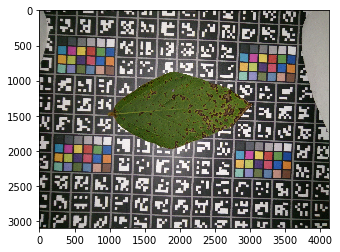

In [ ]:
# Example datapoint: Displaying a leaf image from 'Bacterial Blight' class
ex_path = dataset+'Bacterial Blight/DSC_0038.jpg'
img_ex = cv2.imread(ex_path)
img_rgb = cv2.cvtColor(img_ex, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

<h2> 3.2 Distribution of data points among output classes</h2>


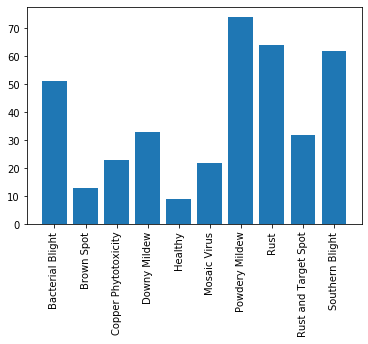

In [ ]:
# Plotting barplots of no.of leaf images w.r.t each disease
plt.bar(img_count.keys(), img_count.values())
plt.xticks(rotation='vertical')
plt.show()

* Total no. of leaf images in dataset is very few (383). There is a need for data-augmentation.
* Dataset is highly imbalanced. We need to perform upsampling techniques.







<h2> 3.3 Data Preparation</h2>

* There are some images in different classes with same image name. So, we rename all the images to avoid duplicate naming. 



In [ ]:
idx = 1   #start index for naming images ex: IMG_0001.jpg
 
for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        src_name = dataset+folder+os.sep+img
        dst_name = dataset+folder+os.sep+'IMG_'+format(idx, '04d')+'.jpg'
        os.rename(src_name, dst_name)
        idx = idx+1

# **4. Deep Learning Models**

* Original leaf images have more background pixels than the actual leaf pixels with non-uniform background. 
* Since, only actual leaf pixels are important, we can crop images or perform some image segmentation techniques. 
* So, we will experiment with 3 different classification models : <br>
    **1. Classification Model on Original Leaf Images**<br>
    **2. Classification Model on Cropped Leaf Images**<br>
    **3. Classification Model on Segmented Leaf Images**

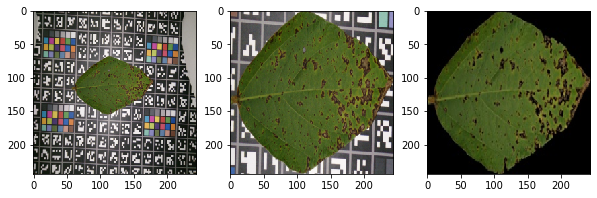

In [ ]:
# Example: Displaying Original, Cropped and Segmented leaf image

path = '/content/drive/My Drive/Leaf Disease Classification/'
img_orig = cv2.imread(path+'Soyabean-Original/Bacterial Blight/IMG_0001.jpg')
img_crop = cv2.imread(path+'Soyabean-Cropped/Bacterial Blight/IMG_CROP_0001.jpg')
img_segt = cv2.imread(path+'Soyabean-Segmented/Bacterial Blight/IMG_SEG_0001.jpg') 

img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
img_segt = cv2.cvtColor(img_segt, cv2.COLOR_BGR2RGB)

img_orig = cv2.resize(img_orig, (244,244), interpolation=cv2.INTER_AREA)
img_crop = cv2.resize(img_crop, (244,244), interpolation=cv2.INTER_AREA)
img_segt = cv2.resize(img_segt, (244,244), interpolation=cv2.INTER_AREA)

f, axs = plt.subplots(1,3, figsize=(10, 3))
axs[0].imshow(img_orig)
axs[1].imshow(img_crop)
axs[2].imshow(img_segt)

In [ ]:
# Importing necessary keras and sklearn libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import tensorflow

import warnings
warnings.filterwarnings('ignore')

from keras import regularizers
from keras.optimizers import *
from keras.callbacks import EarlyStopping, LearningRateScheduler

import itertools
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

Using TensorFlow backend.


In [ ]:
# Credits: AppliedAICourse
def plot_confusion_matrix(test_y, predict_y, labels):

    '''
    This function plots confusion matrix, precision matrix and recall matrix
    using heatmap visualization.

    Parameters:
    test_y: actual output classes
    predict_y: predicted output classes by model
    labels: names of output classes
    '''
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ", (len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

##  **4.1 Classification Model on Soyabean Original Images**

### 4.1.1 Preparing Data

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'
dataset = '/content/drive/My Drive/Leaf Disease Classification/Soyabean-Original/'
folders = os.listdir(dataset)
folders.sort()

In [ ]:
# Storing image data in csv file
img_names = []
img_array = []
labels = []

for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        im = cv2.imread(dataset+folder+os.sep+img)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)

        img_names.append(img)
        img_array.append(im_size)
        labels.append(folder)

df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(path+'Files-Original/soyabean_original.csv', index=False)

# Saving image data in numpy array format
X = np.asarray(img_array)
np.save(path+'Files-Original/imgs_original', X)

In [ ]:
data = pd.read_csv(path+'Files-Original/soyabean_original.csv')
data.head()

Image ID             Class
0  IMG_0001.jpg  Bacterial Blight
1  IMG_0002.jpg  Bacterial Blight
2  IMG_0003.jpg  Bacterial Blight
3  IMG_0004.jpg  Bacterial Blight
4  IMG_0005.jpg  Bacterial Blight

In [ ]:
data['Class'].value_counts()

Powdery Mildew          74
Rust                    64
Southern Blight         62
Bacterial Blight        51
Downy Mildew            33
Rust and Target Spot    32
Copper Phytotoxicity    23
Mosaic Virus            22
Brown Spot              13
Healthy                  9
Name: Class, dtype: int64

In [ ]:
# Mapping original class labels to integer values 
folders = os.listdir(dataset)
folders.sort()

labels = {}
val_cnt = 0
for folder in folders:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1

labels

{'Bacterial Blight': 0,
 'Brown Spot': 1,
 'Copper Phytotoxicity': 2,
 'Downy Mildew': 3,
 'Healthy': 4,
 'Mosaic Virus': 5,
 'Powdery Mildew': 6,
 'Rust': 7,
 'Rust and Target Spot': 8,
 'Southern Blight': 9}

In [ ]:
X = np.load(path+'Files-Original/imgs_original.npy')
y = data['Class'].map(labels).values

data['Image Array'] = X.tolist()
data['Labels'] = y

data.head()

Image ID  ... Labels
0  IMG_0001.jpg  ...      0
1  IMG_0002.jpg  ...      0
2  IMG_0003.jpg  ...      0
3  IMG_0004.jpg  ...      0
4  IMG_0005.jpg  ...      0

[5 rows x 4 columns]

In [ ]:
# Splitting data into train and test
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)

In [ ]:
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()

6    63
7    54
9    53
0    43
3    28
8    27
5    19
2    19
1    11
4     8
Name: Labels, dtype: int64

In [ ]:
# Reference: upsampling in python-https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
majority_class = imbalance_train[imbalance_train.Labels == 6]

# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = [0,1,2,3,4,5,7,8,9]

for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class,
                                  replace = True,
                                  n_samples = majority_class.shape[0], 
                                  random_state = 0)
    upsampled_classes.append(minority_upsampled)

train_upsampled = pd.concat(upsampled_classes) 
print(train_upsampled['Labels'].value_counts())

9    63
8    63
7    63
6    63
5    63
4    63
3    63
2    63
1    63
0    63
Name: Labels, dtype: int64


In [ ]:
train_upsampled.head()

Image Array  Labels
215  [[[16, 21, 10], [110, 101, 83], [136, 132, 121...       6
174  [[[9, 16, 5], [17, 20, 11], [94, 89, 73], [35,...       6
200  [[[20, 24, 14], [21, 24, 15], [39, 43, 30], [4...       6
203  [[[19, 22, 12], [14, 18, 11], [42, 44, 29], [2...       6
162  [[[9, 16, 5], [88, 83, 69], [161, 160, 153], [...       6

In [ ]:
# Shuffling datapoints in a dataframe 
train_shuffled = train_upsampled.sample(frac=1, random_state=0)

X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values

In [ ]:
train_shuffled.head()

Image Array  Labels
145  [[[146, 143, 127], [146, 144, 129], [90, 93, 8...       5
141  [[[123, 124, 108], [120, 120, 106], [27, 34, 2...       5
91   [[[56, 66, 55], [44, 49, 38], [50, 57, 46], [5...       3
84   [[[32, 33, 35], [38, 37, 40], [41, 41, 45], [4...       2
233  [[[33, 40, 36], [7, 10, 4], [8, 10, 5], [19, 2...       7

### 4.1.2 CNN Models

In [ ]:
# Converting class labels into vectorized format
y_train = keras.utils.to_categorical(y_tr1, num_classes=10)
y_test = keras.utils.to_categorical(y_te, num_classes=10)

In [ ]:
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)

X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)

In [ ]:
# Saving final train and test data
np.save(path+'Files-Original/X_train_orig', X_train)
np.save(path+'Files-Original/X_test_orig', X_test)

np.save(path+'Files-Original/y_train_orig', y_train)
np.save(path+'Files-Original/y_test_orig', y_test)

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'
X_train = np.load(path+'Files-Original/X_train_orig.npy') 
X_test = np.load(path+'Files-Original/X_test_orig.npy')

In [ ]:
y_train = np.load(path+'Files-Original/y_train_orig.npy') 
y_test = np.load(path+'Files-Original/y_test_orig.npy')

In [ ]:
print(X_train.shape, X_test.shape)

(630, 144, 144, 3) (58, 144, 144, 3)


In [ ]:
# Scaling pixel values - Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

In [ ]:
# Model parameters
input_shape = (144, 144, 3)
num_classes = 10

In [ ]:
# Performing Data Augmentation on training data
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=4)
steps = int(X_train.shape[0]/4)

#### Model 1

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/model_complex.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/graph_complex', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')

callbacks = [checkpoint, tensorboard]

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Flatten())

model1.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal'))

model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model1.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       7

In [ ]:
history = model1.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=300, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Epoch 1/300
157/157 [==============================] - 5s 32ms/step - loss: 12.7361 - acc: 0.1115 - val_loss: 11.7820 - val_acc: 0.2069

Epoch 00001: val_acc improved from -inf to 0.20690, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/model_complex.h5

Epoch 2/300
157/157 [==============================] - 3s 16ms/step - loss: 13.6507 - acc: 0.1019 - val_loss: 15.3211 - val_acc: 0.0345

Epoch 00002: val_acc did not improve from 0.20690
Epoch 3/300
157/157 [==============================] - 3s 16ms/step - loss: 13.3130 - acc: 0.1417 - val_loss: 11.0055 - val_acc: 0.2586

Epoch 00003: val_acc improved from 0.20690 to 0.25862, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/model_complex.h5
Epoch 4/300
157/157 [==============================] - 3s 16ms/step - loss: 12.6874 - acc: 0.1608 - val_loss: 13.8949 - val_acc: 0.1379

Epoch 000

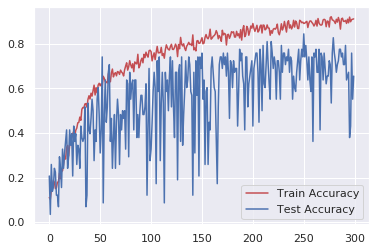

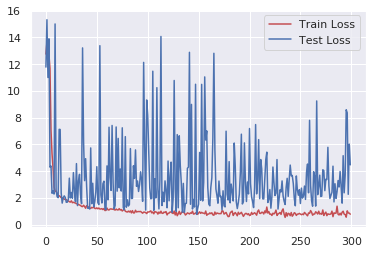

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir '/content/drive/My Drive/Leaf Disease Classification/Results/graph_complex'

In [ ]:
model1.load_weights(path+'Results/Results-Original/model_complex.h5')

In [ ]:
y_pred_tr = model1.predict(X_train)

# Convering categorical representation of output classes into original classes(integers)
# Ex: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] -> 1
y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

train_acc = accuracy_score(y_tr2, y_pred_tr)
print("Train Accuracy : ", train_acc)

Train Accuracy :  0.973015873015873


In [ ]:
y_pred = model1.predict(X_test)

# Convering categorical representation of output classes into original classes(integers)
# Ex: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] -> 1
y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

test_acc = accuracy_score(y_te2, y_pred)
print("Test Accuracy : ", test_acc)

Test Accuracy :  0.8448275862068966


Number of misclassified points  15.517241379310345
-------------------------------------------------- Confusion matrix --------------------------------------------------


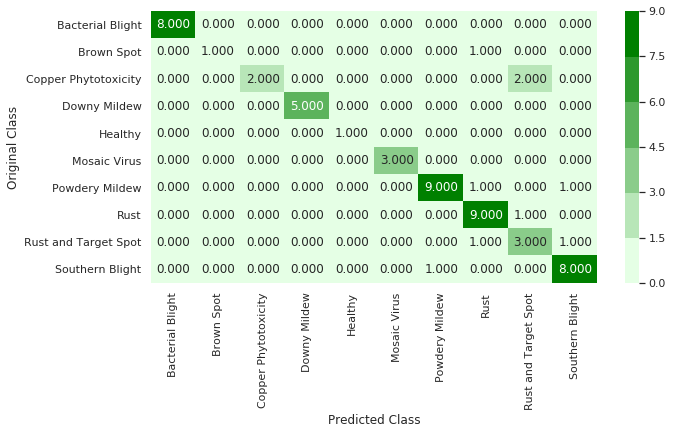

-------------------------------------------------- Precision matrix --------------------------------------------------


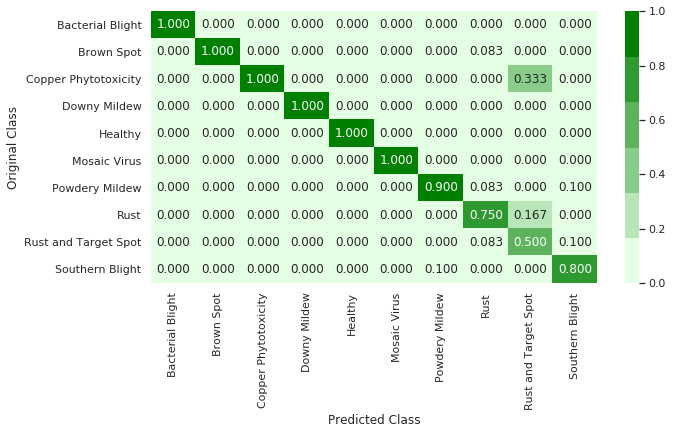

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


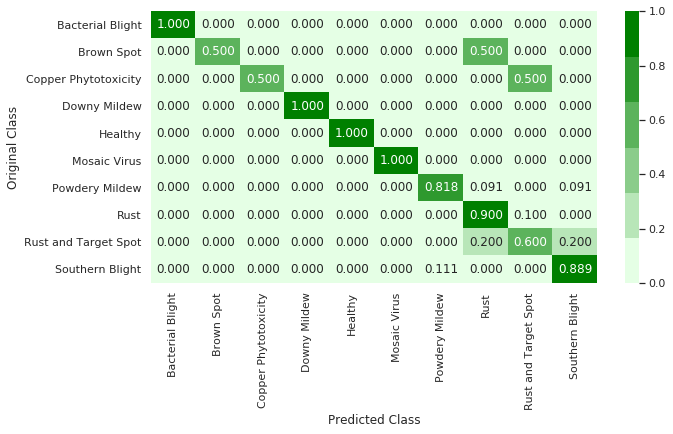

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)

#### Model 2

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/Results-Original/model_11.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/Results-Original/graph_11', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')

callbacks = [checkpoint, tensorboard]

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        32832   

In [ ]:
history = model.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=250, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Epoch 1/250
157/157 [==============================] - 3s 21ms/step - loss: 4.0325 - acc: 0.0717 - val_loss: 2.3081 - val_acc: 0.1552

Epoch 00001: val_acc improved from -inf to 0.15517, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Original/model_11.h5

Epoch 2/250
157/157 [==============================] - 2s 10ms/step - loss: 2.3159 - acc: 0.0860 - val_loss: 2.8490 - val_acc: 0.1379

Epoch 00002: val_acc did not improve from 0.15517
Epoch 3/250
157/157 [==============================] - 2s 10ms/step - loss: 2.3166 - acc: 0.1354 - val_loss: 2.2690 - val_acc: 0.1724

Epoch 00003: val_acc improved from 0.15517 to 0.17241, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Original/model_11.h5
Epoch 4/250
157/157 [==============================] - 1s 10ms/step - loss: 2.1312 - acc: 0.2213 - val_loss: 1.6595 - val_

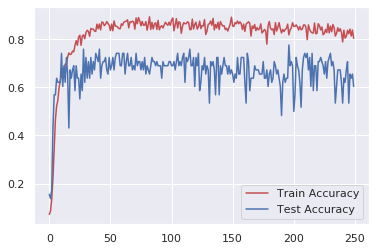

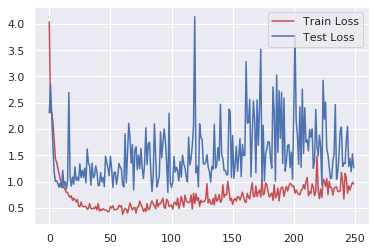

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
model.load_weights(path+'Results/Results-Original/model_11.h5')

In [ ]:
y_pred_tr = model.predict(X_train)

y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

train_acc = accuracy_score(y_tr2, y_pred_tr)
print("Train Accuracy : ", train_acc)

Train Accuracy :  0.9650793650793651


In [ ]:
y_pred = model.predict(X_test)

y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

test_acc = accuracy_score(y_te2, y_pred)
print("Test Accuracy : ", test_acc) 

Test Accuracy :  0.7758620689655172


Number of misclassified points  22.413793103448278
-------------------------------------------------- Confusion matrix --------------------------------------------------


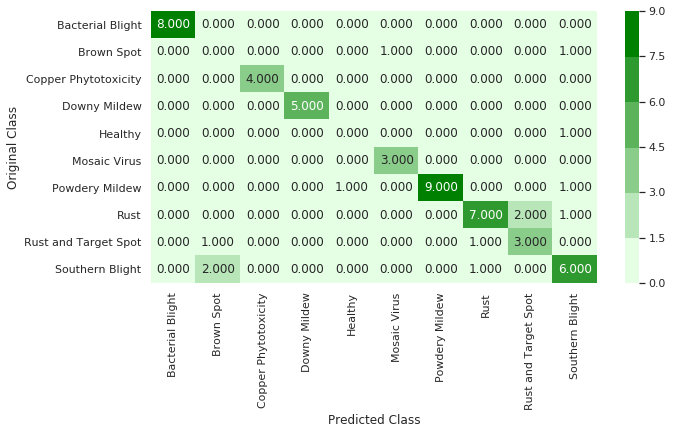

-------------------------------------------------- Precision matrix --------------------------------------------------


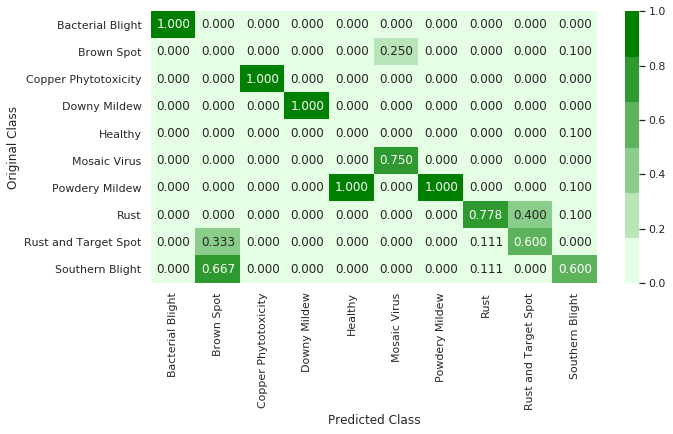

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


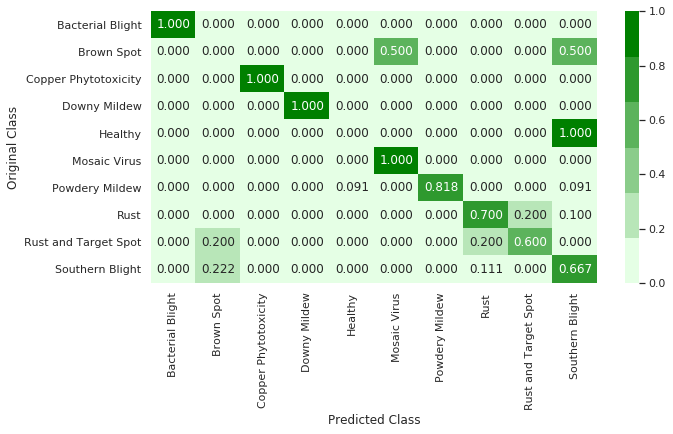

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)

## **4.2 Classification Model on Cropped Leaf Images**

### 4.2.1 Preparing Data

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'
dataset='/content/drive/My Drive/Leaf Disease Classification/Soyabean-Cropped/'
folders = os.listdir(dataset)
folders.sort()

In [ ]:
# Renaming image names as per our convenience
idx = 1
for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        src_name = dataset+folder+os.sep+img
        im_name = 'IMG_CROP_'+format(idx, '04d')+'.jpg'
        dst_name = dataset+folder+os.sep+im_name
        os.rename(src_name, dst_name)

        img_names.append(im_name)
        labels.append(folder)
        idx = idx+1

In [ ]:
# Storing image data in csv file
img_names = []
img_array = []
labels = []

for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        im = cv2.imread(dataset+folder+os.sep+img)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)

        img_names.append(img)
        img_array.append(im_size)
        labels.append(folder)

df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(path+'Files-Cropped/soyabean_cropped.csv', index=False)

# Saving image data in numpy array format
X = np.asarray(img_array)
np.save(path+'Files-Cropped/imgs_original', X)

In [ ]:
data = pd.read_csv(path+'Files-Cropped/soyabean_cropped.csv')
data.head()

Image ID             Class
0  IMG_CROP_0001.jpg  Bacterial Blight
1  IMG_CROP_0002.jpg  Bacterial Blight
2  IMG_CROP_0003.jpg  Bacterial Blight
3  IMG_CROP_0004.jpg  Bacterial Blight
4  IMG_CROP_0005.jpg  Bacterial Blight

In [ ]:
data['Class'].value_counts()

Powdery Mildew          74
Rust                    64
Southern Blight         62
Bacterial Blight        51
Downy Mildew            33
Rust and Target Spot    32
Copper Phytotoxicity    23
Mosaic Virus            22
Brown Spot              13
Healthy                  9
Name: Class, dtype: int64

In [ ]:
# Mapping original class labels to integer values 
folders = os.listdir(dataset)
folders.sort()

labels = {}
val_cnt = 0
for folder in folders:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1

labels

{'Bacterial Blight': 0,
 'Brown Spot': 1,
 'Copper Phytotoxicity': 2,
 'Downy Mildew': 3,
 'Healthy': 4,
 'Mosaic Virus': 5,
 'Powdery Mildew': 6,
 'Rust': 7,
 'Rust and Target Spot': 8,
 'Southern Blight': 9}

In [ ]:
X = np.load(path+'Files-Cropped/imgs_original.npy')
y = data['Class'].map(labels).values

data['Image Array'] = X.tolist()
data['Labels'] = y

data.head()

Image ID  ... Labels
0  IMG_CROP_0001.jpg  ...      0
1  IMG_CROP_0002.jpg  ...      0
2  IMG_CROP_0003.jpg  ...      0
3  IMG_CROP_0004.jpg  ...      0
4  IMG_CROP_0005.jpg  ...      0

[5 rows x 4 columns]

In [ ]:
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)

In [ ]:
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()

6    63
7    54
9    53
0    43
3    28
8    27
5    19
2    19
1    11
4     8
Name: Labels, dtype: int64

In [ ]:
# Reference: upsampling in python-https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
majority_class = imbalance_train[imbalance_train.Labels == 6]

# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = [0,1,2,3,4,5,7,8,9]

for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class,
                                  replace = True,
                                  n_samples = majority_class.shape[0], 
                                  random_state = 0)
    upsampled_classes.append(minority_upsampled)

train_upsampled = pd.concat(upsampled_classes) 
print(train_upsampled['Labels'].value_counts())

9    63
8    63
7    63
6    63
5    63
4    63
3    63
2    63
1    63
0    63
Name: Labels, dtype: int64


In [ ]:
train_upsampled.head()

Image Array  Labels
215  [[[124, 120, 122], [133, 126, 128], [130, 125,...       6
174  [[[94, 82, 88], [95, 84, 91], [98, 82, 92], [9...       6
200  [[[238, 237, 237], [239, 236, 235], [186, 181,...       6
203  [[[127, 124, 127], [130, 126, 129], [130, 124,...       6
162  [[[74, 69, 73], [72, 71, 68], [68, 69, 64], [6...       6

In [ ]:
train_shuffled = train_upsampled.sample(frac=1, random_state=0)
train_shuffled.head()

Image Array  Labels
145  [[[63, 60, 75], [216, 210, 209], [222, 214, 21...       5
141  [[[30, 30, 24], [29, 30, 24], [27, 30, 27], [2...       5
91   [[[177, 166, 167], [174, 167, 165], [115, 108,...       3
84   [[[54, 48, 52], [48, 46, 45], [50, 48, 46], [5...       2
233  [[[62, 60, 56], [73, 69, 76], [181, 176, 176],...       7

In [ ]:
X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values

### 4.2.2 CNN Models

In [ ]:
y_train = keras.utils.to_categorical(y_tr1, num_classes=10)
y_test = keras.utils.to_categorical(y_te, num_classes=10)

In [ ]:
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)

X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)

In [ ]:
np.save(path+'Files-Cropped/X_train_orig', X_train)
np.save(path+'Files-Cropped/X_test_orig', X_test)

np.save(path+'Files-Cropped/y_train_orig', y_train)
np.save(path+'Files-Cropped/y_test_orig', y_test)

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'
X_train = np.load(path+'Files-Cropped/X_train_orig.npy') 
X_test = np.load(path+'Files-Cropped/X_test_orig.npy')

In [ ]:
y_train = np.load(path+'Files-Cropped/y_train_orig.npy') 
y_test = np.load(path+'Files-Cropped/y_test_orig.npy')

In [ ]:
print(X_train.shape, X_test.shape)

(630, 144, 144, 3) (58, 144, 144, 3)


In [ ]:
# Scaling pixel values - Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

In [ ]:
# Model parameters
input_shape = (144, 144, 3)
num_classes = 10

In [ ]:
# Performing Data Augmentation on training data
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=4)
steps = int(X_train.shape[0]/4)

#### Model 1

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/Results-Cropped/model_2.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/Results-Cropped/graph_2', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')

callbacks = [checkpoint, tensorboard]

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Flatten())

model2.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu', kernel_initializer='he_normal'))

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 128)      

In [ ]:
history = model2.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=300, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Epoch 1/300
157/157 [==============================] - 5s 35ms/step - loss: 13.0292 - acc: 0.1147 - val_loss: 15.1363 - val_acc: 0.0345

Epoch 00001: val_acc improved from -inf to 0.03448, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/model_2.h5

Epoch 2/300
157/157 [==============================] - 3s 18ms/step - loss: 13.0802 - acc: 0.1561 - val_loss: 15.1412 - val_acc: 0.0517

Epoch 00002: val_acc improved from 0.03448 to 0.05172, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/model_2.h5
Epoch 3/300
157/157 [==============================] - 3s 18ms/step - loss: 13.4122 - acc: 0.1449 - val_loss: 13.1482 - val_acc: 0.1724

Epoch 00003: val_acc improved from 0.05172 to 0.17241, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/model_2.h5
Epoch 4/300
157/15

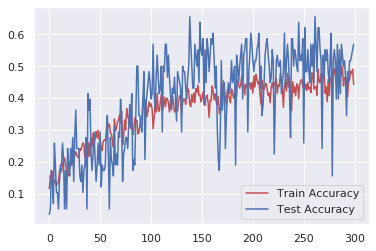

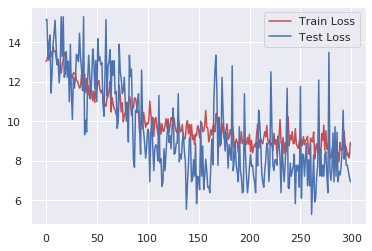

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/graph_2'

In [ ]:
model2.load_weights(path+'Results/Results-Cropped/model_2.h5')

In [ ]:
y_pred_tr = model2.predict(X_train)

y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

print("Train Accuracy: ", accuracy_score(y_tr2, y_pred_tr))

Train Accuracy:  0.49206349206349204


In [ ]:
y_pred = model2.predict(X_test)

y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

print("Test Accuracy: ", accuracy_score(y_te2, y_pred))

Test Accuracy:  0.6551724137931034


Number of misclassified points  34.48275862068966
-------------------------------------------------- Confusion matrix --------------------------------------------------


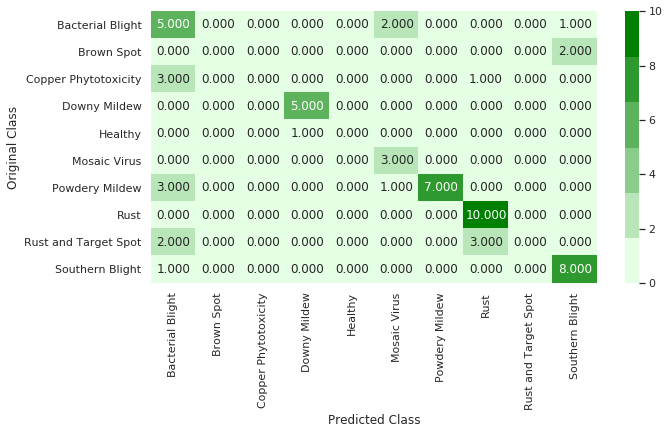

-------------------------------------------------- Precision matrix --------------------------------------------------


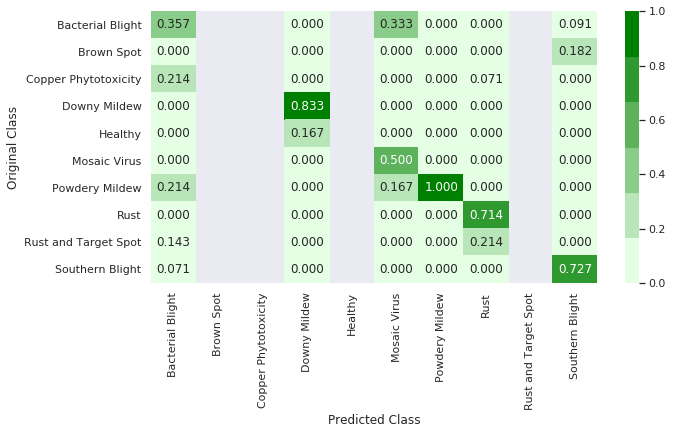

Sum of columns in precision matrix [ 1. nan nan  1. nan  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


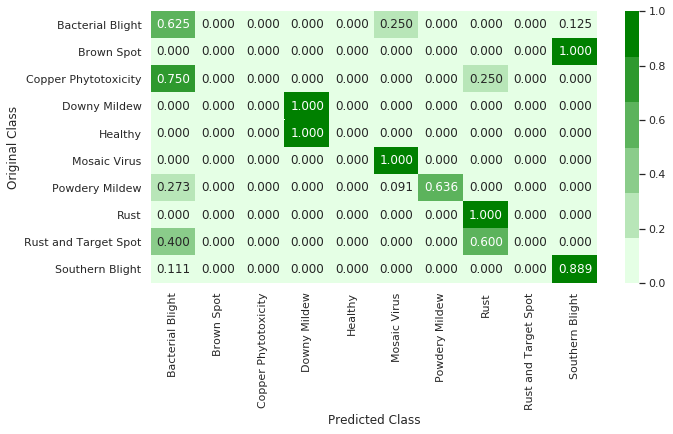

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)

#### Model 2

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/Results-Cropped/model_21.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/Results-Cropped/graph_21', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')
#reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', mode="max", factor = 0.85, patience = 12, verbose = 1, min_delta = 0.005)
callbacks = [checkpoint, tensorboard]

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 36, 128)       32896     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 36, 36, 64)        32832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)       

In [ ]:
history = model.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=300, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Epoch 1/300
157/157 [==============================] - 4s 24ms/step - loss: 2.4825 - acc: 0.1592 - val_loss: 2.8971 - val_acc: 0.1552

Epoch 00001: val_acc improved from -inf to 0.15517, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/model_21.h5

Epoch 2/300
157/157 [==============================] - 2s 12ms/step - loss: 2.0083 - acc: 0.2787 - val_loss: 2.7851 - val_acc: 0.1034

Epoch 00002: val_acc did not improve from 0.15517
Epoch 3/300
157/157 [==============================] - 2s 12ms/step - loss: 1.9852 - acc: 0.2659 - val_loss: 1.7167 - val_acc: 0.2759

Epoch 00003: val_acc improved from 0.15517 to 0.27586, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/model_21.h5
Epoch 4/300
157/157 [==============================] - 2s 12ms/step - loss: 1.7510 - acc: 0.3726 - val_loss: 13.3391 - val_a

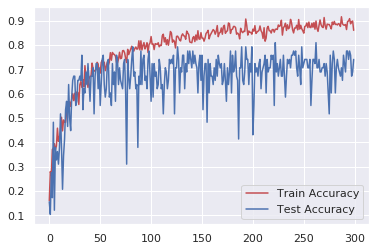

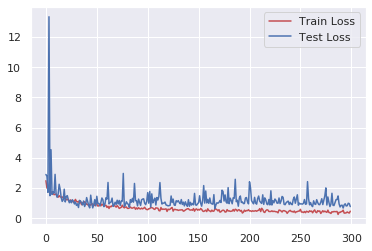

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/My Drive/Leaf Disease Classification/Results/Results-Cropped/graph_21'

In [ ]:
model.load_weights(path+'Results/Results-Cropped/model_21.h5')

In [ ]:
y_pred_tr = model.predict(X_train)

y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

print("Train Accuracy: ", accuracy_score(y_tr2, y_pred_tr))

Train Accuracy:  0.9873015873015873


In [ ]:
y_pred = model.predict(X_test)

y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

print("Test Accuracy: ", accuracy_score(y_te2, y_pred))

Test Accuracy:  0.8103448275862069


Number of misclassified points  18.96551724137931
-------------------------------------------------- Confusion matrix --------------------------------------------------


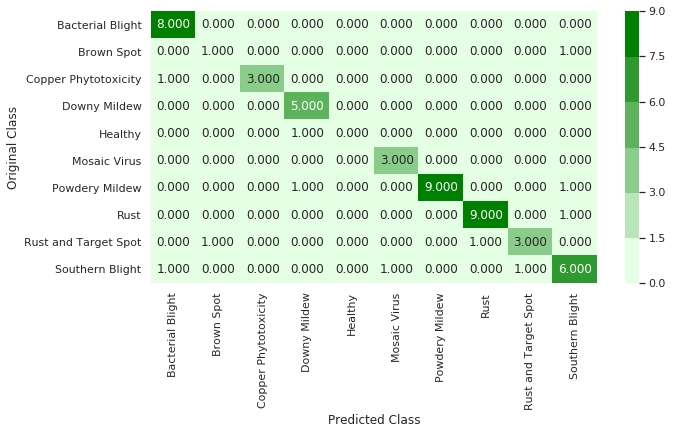

-------------------------------------------------- Precision matrix --------------------------------------------------


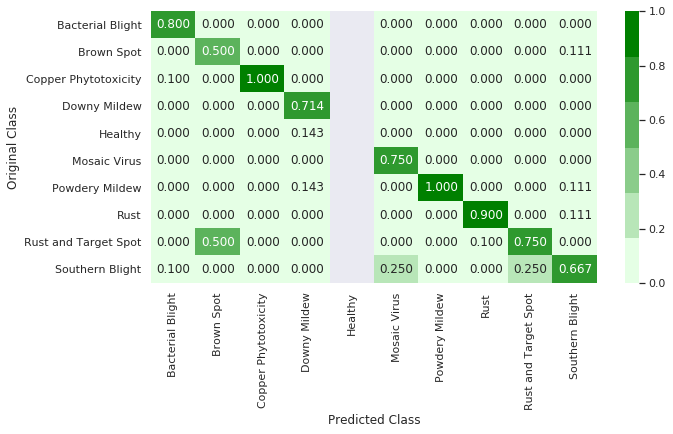

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


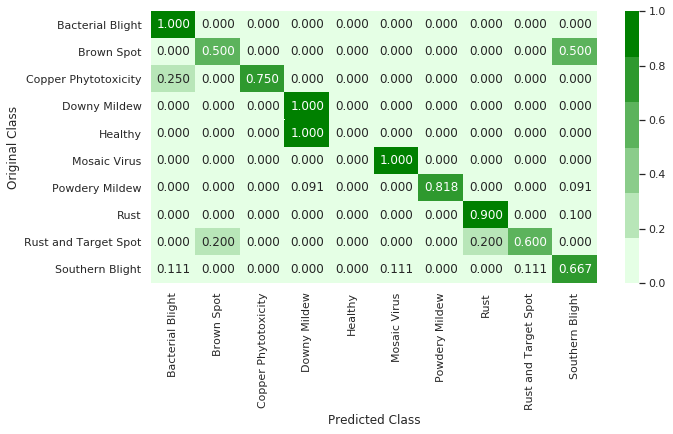

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)


## **4.3 Classification Model on Segmented Leaf Images**

### 4.3.1 Leaf Image Segmentation using K-means Clustering Method

#### (a) Finding the best color space channel for color segmentation

In [ ]:
# Here, we are trying different color spaces to find best color channel.
image = cv2.imread('/content/drive/My Drive/Leaf Disease Classification/Soyabean-Original/Bacterial Blight/IMG_0001.jpg')

img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

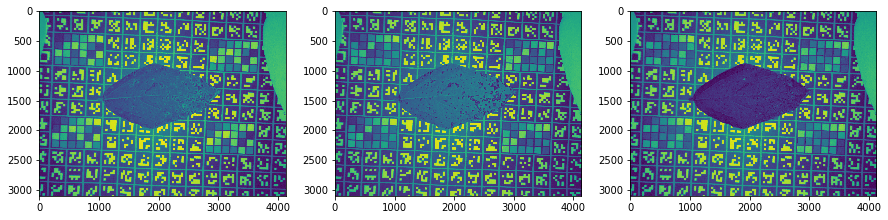

In [ ]:
# RGB Channel
R = img_rgb[:, :, 0]
G = img_rgb[:, :, 1]
B = img_rgb[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(R)
ax[1].imshow(G)
ax[2].imshow(B)

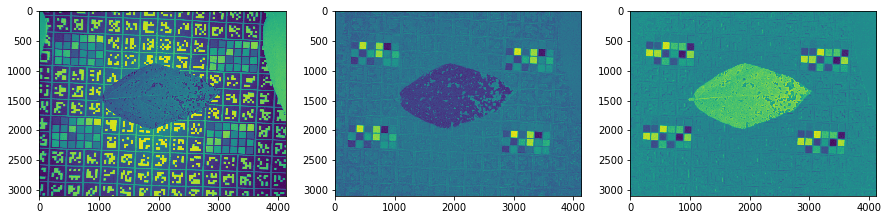

In [ ]:
# Lab Color Space - https://en.wikipedia.org/wiki/CIELAB_color_space
L = img_lab[:, :, 0]
a = img_lab[:, :, 1]
b = img_lab[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(L)
ax[1].imshow(a)
ax[2].imshow(b)

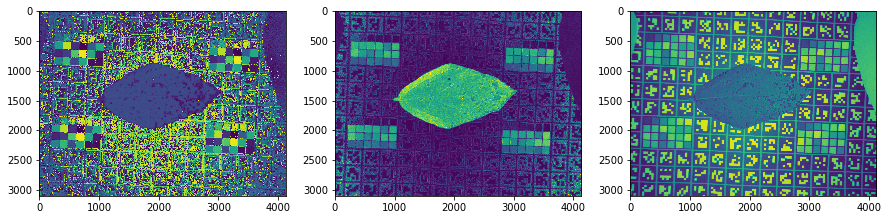

In [ ]:
# HSV Color Space - https://en.wikipedia.org/wiki/HSL_and_HSV
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(H)
ax[1].imshow(S)
ax[2].imshow(V)

<h3><b>From above, we can conclude 'b' channel from LAB color model is useful for color segmentation.</b></h3>

#### (b) K-means clustering on b channel of Lab color space

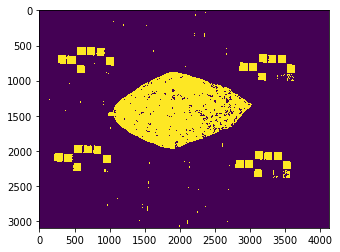

In [ ]:
# K-means clustering in opencv - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
pixel_vals = b.flatten()
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Since we are interested in only actual leaf pixels, we choose 2 clusters 
# one cluster for actual leaf pixels and other for unwanted background pixels.
K = 2 
retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((b.shape))
pixel_labels = labels.reshape(img_lab.shape[0], img_lab.shape[1])

# displaying segmented image
plt.imshow(segmented_image)

#### (c) Finding connected components in 2-clustered pixel labels

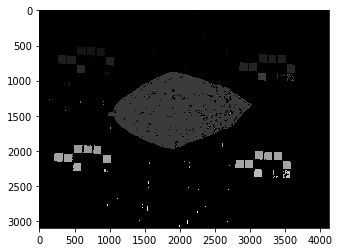

In [ ]:
# Now, we find connected components among clustered pixels 
# Doing this, some unwanted pixels that are clustered in main cluster can be avoided.
# Ref - https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gac2718a64ade63475425558aa669a943a 
pixel_labels = np.uint8(pixel_labels)
ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)
plt.imshow(components, cmap='gray')

#### (d) Finding the main cluster to which actual leaf belongs 

In [ ]:
# Here, we find the component in main cluster where actual leaf pixels lie
# Logic: largest component has actual leaf pixels
# So, we find largest component using max no. of rows/cols in components 
indices = []
for i in range(1, ret):
    row, col = np.where(components==i)
    indices.append(max(len(row), len(col)))

cluster = np.argmax(np.array(indices))
cluster = cluster+1   #indexing starts from 0, so we increment by 1 to get actual cluster index

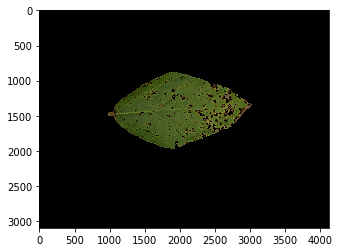

In [ ]:
# creating a mask and extracting pixels corresponding to cluster to which leaf belongs.
# 1 for actual leaf pixels and 0 for other pixels
mask = np.where(components==cluster, 1, 0)

B = image[:, :, 0]
G = image[:, :, 1]
R = image[:, :, 2]

# Extract only masked pixels
r = R*mask
g = G*mask
b = B*mask

final_img = np.dstack((r, g, b))
plt.imshow(final_img)

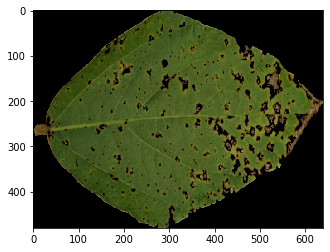

In [ ]:
# Cropping the image by removing surrounding black pixels
# Remove rows and columns where pixels are 0
v_sum = np.sum(fi1, axis=0)
h_sum = np.sum(fi1, axis=1)

w = np.count_nonzero(v_sum)
h = np.count_nonzero(h_sum)

x_indices = np.where(v_sum != 0)
y_indices = np.where(h_sum != 0)

x = x_indices[0][0]
y = y_indices[0][0]

final_crop_img = final_img[y:y+h-1, x:x+w-1, :]
final_crop_img = np.uint8(final_crop_img)
img = cv2.resize(final_crop_img,(640,480),interpolation=cv2.INTER_AREA)
plt.imshow(img)

#### (e) Function to perform image segmentation

In [ ]:
src_dataset = '/content/drive/My Drive/Leaf Disease Classification/Soyabean-Original/'
dest_dataset = '/content/drive/My Drive/Leaf Disease Classification/Soyabean-Segmented/'

folders = os.listdir(src_dataset)
folders.sort()

In [ ]:
for folder in folders:
    src_folder = src_dataset+folder+os.sep
    
    # creating destination folders for saving preprocessed images
    os.mkdir(dest_dataset+folder+os.sep)  
    dest_folder = dest_dataset+folder+os.sep

    imgs = os.listdir(src_folder)
    for img in imgs:
        image_segmentation(img, src_folder, dest_folder)

In [ ]:
def image_segmentation(imgname, src_folder, dest_folder):
    '''
    This function performs image segmentation on raw images based on
    K-means clustering.

    Parameters: 
    imgname - image name of given image belonging to some class
    src_folder - directory/folder where image is stored
    dest_folder - directoy/folder where segmented image is stored
    '''
    image = cv2.imread(src_folder+imgname)

    # Converting RGB->Lab color space 
    img_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    b = img_cvt[:, :, 2] 
    pixel_vals = b.flatten()
    pixel_vals = np.float32(pixel_vals)

    # Performing K-means clustering on 'b' channel of image
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    retval, labels, centers = cv2.kmeans(pixel_vals, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    pixel_labels = labels.reshape(image.shape[0], image.shape[1])

    # Finding connected components in clusters    
    ret, components = cv2.connectedComponents(pixel_labels, connectivity=8)

    # Finding row & col indices of connected components
    indices = []
    for i in range(1, ret):
        row, col = np.where(components==i)
        indices.append(len(col))

    cluster = np.argmax(np.array(indices))
    cluster = cluster+1

    mask = np.where(components==cluster, 1, 0)

    B = image[:, :, 0]
    G = image[:, :, 1]
    R = image[:, :, 2]

    r = R*mask
    g = G*mask
    b = B*mask

    final_img = np.dstack((r, g, b))

    # Finding x&y indices to crop image
    v_sum = np.sum(mask, axis=0)
    h_sum = np.sum(mask, axis=1)

    w = np.count_nonzero(v_sum)
    h = np.count_nonzero(h_sum)

    x_indices = np.where(v_sum != 0)
    y_indices = np.where(h_sum != 0)

    x = x_indices[0][0]
    y = y_indices[0][0]

    final_crop_img = final_img[y:y+h-1, x:x+w-1, :]
    final_crop_img = np.uint8(final_crop_img)

    # Resizing Image
    im_resize = cv2.resize(final_crop_img,(640,480),interpolation=cv2.INTER_AREA)
    im_resize = cv2.cvtColor(im_resize, cv2.COLOR_RGB2BGR)
    cv2.imwrite(dest_folder+imgname, im_resize)

### 4.3.2 Preparing Data

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'
dataset = '/content/drive/My Drive/Leaf Disease Classification/Soyabean-Segmented/'
folders = os.listdir(dataset)
folders.sort()

In [ ]:
# Renaming image names as per our convenience
idx = 1
for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        src_name = dataset+folder+os.sep+img
        dst_name = dataset+folder+os.sep+'IMG_SEG_'+format(idx, '04d')+'.jpg'
        os.rename(src_name, dst_name)
        idx = idx+1

In [ ]:
# Storing image data in csv file
img_names = []
img_array = []
labels = []

for folder in folders:    
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()

    for img in imgs:
        im = cv2.imread(dataset+folder+os.sep+img)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)

        img_names.append(img)
        img_array.append(im_size)
        labels.append(folder)

df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(path+'Files-Segmented/soyabean_segmented.csv', index=False)

X = np.asarray(img_array)
np.save(path+'Files-Segmented/imgs_original', X)

In [ ]:
data = pd.read_csv(path+'Files-Segmented/soyabean_segmented.csv')
data.head()

Image ID             Class
0  IMG_SEG_0001.jpg  Bacterial Blight
1  IMG_SEG_0002.jpg  Bacterial Blight
2  IMG_SEG_0003.jpg  Bacterial Blight
3  IMG_SEG_0004.jpg  Bacterial Blight
4  IMG_SEG_0005.jpg  Bacterial Blight

In [ ]:
data['Class'].value_counts()

Powdery Mildew          74
Rust                    64
Southern Blight         62
Bacterial Blight        51
Downy Mildew            33
Rust and Target Spot    32
Copper Phytotoxicity    23
Mosaic Virus            22
Brown Spot              13
Healthy                  7
Name: Class, dtype: int64

In [ ]:
# Mapping original class labels to integer values 
folders = os.listdir(dataset)
folders.sort()

labels = {}
val_cnt = 0
for folder in folders:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1

labels

{'Bacterial Blight': 0,
 'Brown Spot': 1,
 'Copper Phytotoxicity': 2,
 'Downy Mildew': 3,
 'Healthy': 4,
 'Mosaic Virus': 5,
 'Powdery Mildew': 6,
 'Rust': 7,
 'Rust and Target Spot': 8,
 'Southern Blight': 9}

In [ ]:
X = np.load(path+'Files-Segmented/imgs_original.npy')
y = data['Class'].map(labels).values

data['Image Array'] = X.tolist()
data['Labels'] = y

data.head()

Image ID  ... Labels
0  IMG_SEG_0001.jpg  ...      0
1  IMG_SEG_0002.jpg  ...      0
2  IMG_SEG_0003.jpg  ...      0
3  IMG_SEG_0004.jpg  ...      0
4  IMG_SEG_0005.jpg  ...      0

[5 rows x 4 columns]

In [ ]:
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)

In [ ]:
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()

6    63
7    54
9    53
0    43
3    28
8    27
5    19
2    19
1    11
4     6
Name: Labels, dtype: int64

In [ ]:
# Reference: upsampling in python-https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
majority_class = imbalance_train[imbalance_train.Labels == 6]

# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = [0,1,2,3,4,5,7,8,9]

for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class,
                                  replace = True,
                                  n_samples = majority_class.shape[0], 
                                  random_state = 0)
    upsampled_classes.append(minority_upsampled)

train_upsampled = pd.concat(upsampled_classes) 
print(train_upsampled['Labels'].value_counts())

9    63
8    63
7    63
6    63
5    63
4    63
3    63
2    63
1    63
0    63
Name: Labels, dtype: int64


In [ ]:
train_upsampled.head()

Image Array  Labels
215  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6
202  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6
222  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6
211  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6
212  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       6

In [ ]:
train_shuffled = train_upsampled.sample(frac=1, random_state=0)
train_shuffled.head()

Image Array  Labels
142  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       5
137  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       5
91   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       3
84   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       2
247  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       7

In [ ]:
X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values

### 4.3.3 CNN Models

In [ ]:
y_train = keras.utils.to_categorical(y_tr1, num_classes=10)
y_test = keras.utils.to_categorical(y_te, num_classes=10)

In [ ]:
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)

X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)

In [ ]:
np.save(path+'Files-Segmented/X_train_orig', X_train)
np.save(path+'Files-Segmented/X_test_orig', X_test)

np.save(path+'Files-Segmented/y_train_orig', y_train)
np.save(path+'Files-Segmented/y_test_orig', y_test)

In [ ]:
path = '/content/drive/My Drive/Leaf Disease Classification/'

X_train = np.load(path+'Files-Segmented/X_train_orig.npy') 
X_test = np.load(path+'Files-Segmented/X_test_orig.npy')

y_train = np.load(path+'Files-Segmented/y_train_orig.npy') 
y_test = np.load(path+'Files-Segmented/y_test_orig.npy')

In [ ]:
print(X_train.shape, X_test.shape)

(630, 144, 144, 3) (58, 144, 144, 3)


In [ ]:
# Scaling pixel values - Normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

In [ ]:
# Model parameters
input_shape = (144, 144, 3)
num_classes = 10

In [ ]:
# Performing Data Augmentation on training data
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=4)
steps = int(X_train.shape[0]/4)

#### Model 1

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/Results-Segmented/model_3.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/Results-Segmented/graph_3', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')

callbacks = [checkpoint, tensorboard]

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Flatten())

model1.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal'))

model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 128)     

In [ ]:
history = model1.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=300, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Epoch 1/300
157/157 [==============================] - 5s 33ms/step - loss: 13.1969 - acc: 0.1242 - val_loss: 13.1396 - val_acc: 0.1379

Epoch 00001: val_acc improved from -inf to 0.13793, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Segmented/model_3.h5

Epoch 2/300
157/157 [==============================] - 3s 16ms/step - loss: 13.5754 - acc: 0.1115 - val_loss: 13.1982 - val_acc: 0.1379

Epoch 00002: val_acc did not improve from 0.13793
Epoch 3/300
157/157 [==============================] - 3s 17ms/step - loss: 13.7187 - acc: 0.1131 - val_loss: 14.4488 - val_acc: 0.1034

Epoch 00003: val_acc did not improve from 0.13793
Epoch 4/300
157/157 [==============================] - 3s 17ms/step - loss: 13.3979 - acc: 0.1465 - val_loss: 12.6797 - val_acc: 0.1552

Epoch 00004: val_acc improved from 0.13793 to 0.15517, saving model to /content/drive/My Drive/

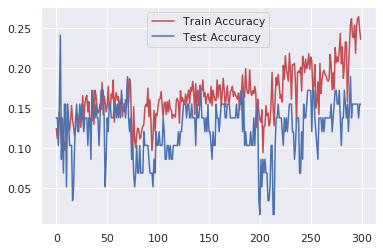

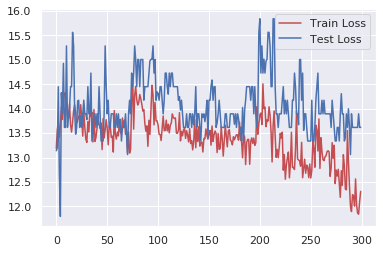

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
model1.load_weights(path+'Results/Results-Segmented/model_3.h5')

In [ ]:
y_pred_tr = model1.predict(X_train)

y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

train_acc = accuracy_score(y_tr2, y_pred_tr)
print("Train Accuracy : ", train_acc)

Train Accuracy :  0.18253968253968253


In [ ]:
y_pred = model1.predict(X_test)

y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

test_acc = accuracy_score(y_te2, y_pred)
print("Test Accuracy : ", test_acc)

Test Accuracy :  0.2413793103448276


Number of misclassified points  75.86206896551724
-------------------------------------------------- Confusion matrix --------------------------------------------------


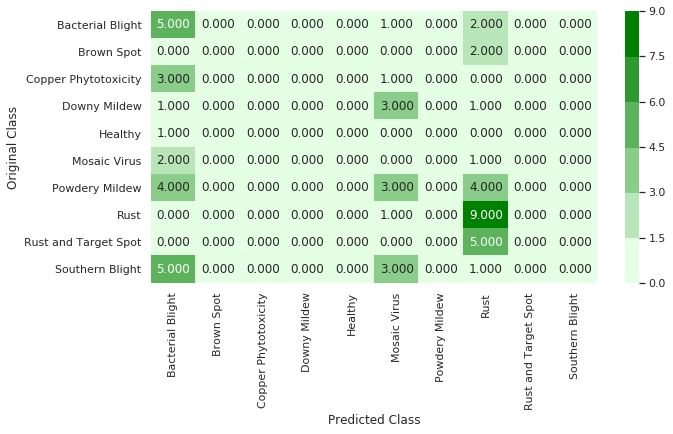

-------------------------------------------------- Precision matrix --------------------------------------------------


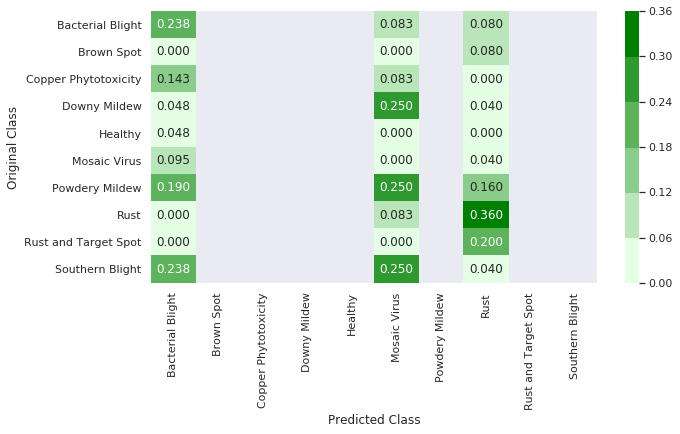

Sum of columns in precision matrix [ 1. nan nan nan nan  1. nan  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


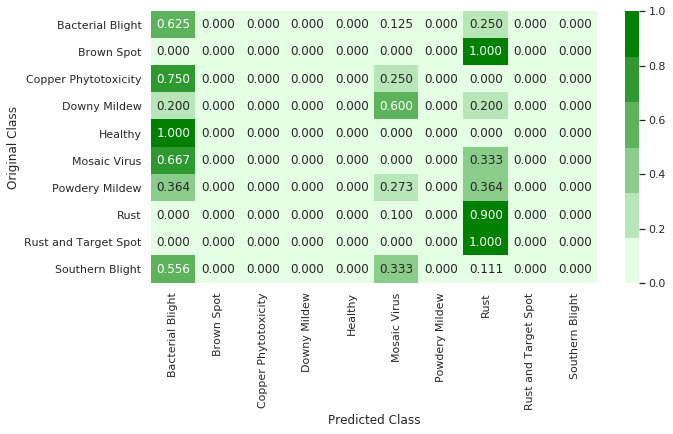

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)

#### Model 2

In [ ]:
# Saving model weights and other important parameters 
checkpoint = ModelCheckpoint(path+"Results/Results-Segmented/model_31.h5", monitor="val_acc",
                             mode="max", save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=path+'Results/Results-Segmented/graph_31', histogram_freq=4, batch_size=4, 
                          update_freq='epoch')

callbacks = [checkpoint, tensorboard]

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2), 
                 kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same', strides=(1, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        32832   

In [ ]:
history = model.fit_generator(it_train, steps_per_epoch=steps,
                              epochs=250, validation_data=(X_test, y_test),
                              verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Epoch 1/250
157/157 [==============================] - 3s 21ms/step - loss: 2.2716 - acc: 0.1592 - val_loss: 1.7158 - val_acc: 0.3621

Epoch 00001: val_acc improved from -inf to 0.36207, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Segmented/model_31.h5

Epoch 2/250
157/157 [==============================] - 2s 10ms/step - loss: 1.8547 - acc: 0.3041 - val_loss: 1.6105 - val_acc: 0.3793

Epoch 00002: val_acc improved from 0.36207 to 0.37931, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Segmented/model_31.h5
Epoch 3/250
157/157 [==============================] - 2s 10ms/step - loss: 1.6480 - acc: 0.4029 - val_loss: 1.4003 - val_acc: 0.3966

Epoch 00003: val_acc improved from 0.37931 to 0.39655, saving model to /content/drive/My Drive/Leaf Disease Classification/Results/Results-Segmented/model_31.h5
Epoch 4/2

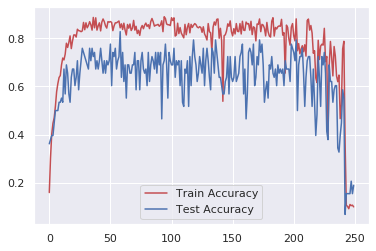

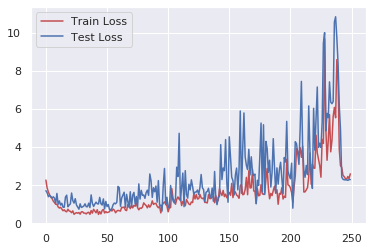

In [ ]:
sns.set()
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/My Drive/Leaf Disease Classification/Results/Results-Segmented/graph_31'

In [ ]:
model.load_weights(path+'Results/Results-Segmented/model_31.h5')

In [ ]:
y_pred_tr = model.predict(X_train)

y_tr2 = y_train.argmax(1)
y_pred_tr = y_pred_tr.argmax(1)

train_acc = accuracy_score(y_tr2, y_pred_tr)
print("Train Accuracy : ", train_acc)

Train Accuracy :  0.9619047619047619


In [ ]:
y_pred = model.predict(X_test)

y_te2 = y_test.argmax(1)
y_pred = y_pred.argmax(1)

test_acc = accuracy_score(y_te2, y_pred)
print("Test Accuracy : ", test_acc)

Test Accuracy :  0.8275862068965517


Number of misclassified points  17.24137931034483
-------------------------------------------------- Confusion matrix --------------------------------------------------


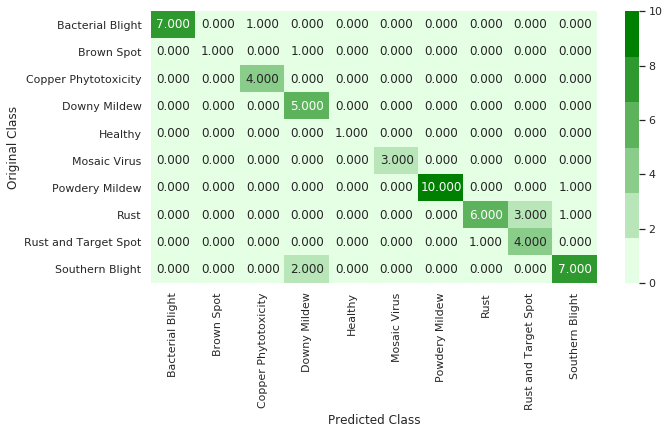

-------------------------------------------------- Precision matrix --------------------------------------------------


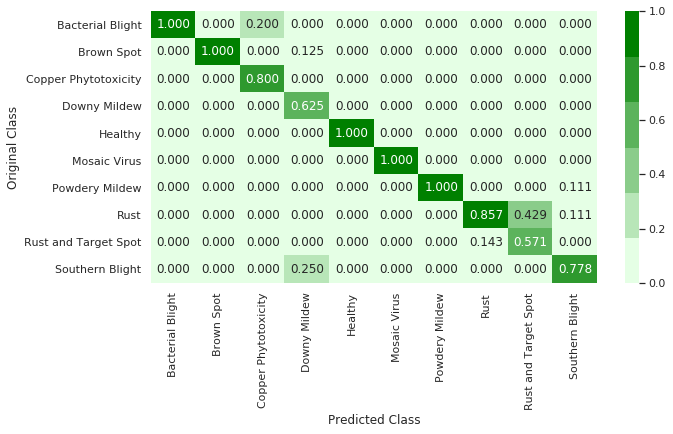

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


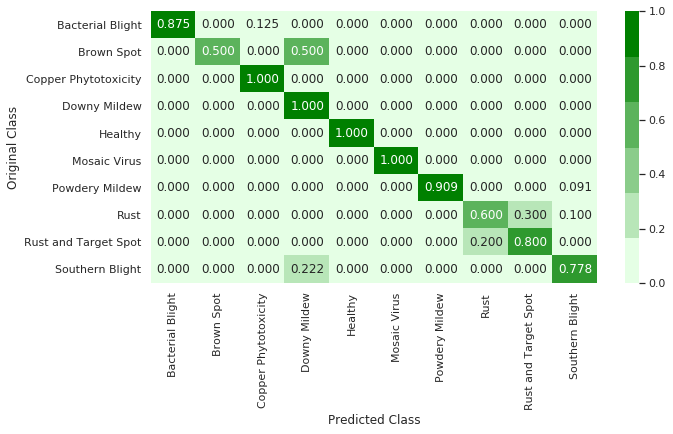

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(test_y=y_te2, predict_y=y_pred, labels=folders)


# **5. Results**

*   We have experimented two different cnn model architectures on original, cropped and segmented datasets.
*   The results obtained from the above models are provided in below table.



In [ ]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Dataset Type", "CNN Model", "Train Accuracy", "Test Accuracy" ]
x.add_row(["Original Images", "Model 1 ", 97.3015, 84.4827])
x.add_row(["Original Images", "Model 2", 96.5079, 77.5862 ])
x.add_row(["Cropped Images", "Model 1", 49.2063, 65.5172 ])
x.add_row(["Cropped Images", "Model 2", 98.7301, 81.0344])
x.add_row(["Segmented Images", "Model 1", 18.2539, 24.1379 ])
x.add_row(["Segmented Images", "Model 2", 96.1905, 82.7586 ])

print(x)

+------------------+-----------+----------------+---------------+
|   Dataset Type   | CNN Model | Train Accuracy | Test Accuracy |
+------------------+-----------+----------------+---------------+
| Original Images  |  Model 1  |    97.3015     |    84.4827    |
| Original Images  |  Model 2  |    96.5079     |    77.5862    |
|  Cropped Images  |  Model 1  |    49.2063     |    65.5172    |
|  Cropped Images  |  Model 2  |    98.7301     |    81.0344    |
| Segmented Images |  Model 1  |    18.2539     |    24.1379    |
| Segmented Images |  Model 2  |    96.1905     |    82.7586    |
+------------------+-----------+----------------+---------------+


# **6. Conclusions**

1. In this case study, two different CNN architectures are built on original, cropped and segmented soyabean leaf images.
2. Since, dataset is too small, data augmentation is performed.
3. Due to highly imbalanced dataset, upsampling techniques are used.
4. Because of small and highly imbalanced dataset, the performance of models on some datasets are poor.
5. Both model1 and model2 gave good results for original images.
6. From, confusion, precision and recall matrices, it is observed that 'Rust' and 'Rust and Target Spot' classes are misclassified because images of these classes are mostly similar.
7. And also it is observed that some classes have high variance in colors for images belonging to same class. Due to this, achieving best results is difficult.  
8. Although, dataset is very small and highly imbalanced, better results are achieved in following cases:
    * Model 1 - Original Images
    * Model 2 - Segmented and Cropped Images
9. Because of dataset structure, best model cannot be justified. But, among all models, model 1 on original images is the best.
10. CNN Models on original images have given better performance than cropped images and segmented images.
11. If dataset is large, the performance of the models might further improve.
12. It seems that image segmentation technique might also give better results for larger results. 